In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import hbar
from sympy import Matrix
from scipy.integrate import solve_ivp

paper for this document: https://arxiv.org/pdf/2205.14621.pdf
https://journals.aps.org/pra/pdf/10.1103/PhysRevA.65.022314

about rydberg excitation rate (inchoerent regime)
https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.111.215305
https://journals.aps.org/pra/pdf/10.1103/PhysRevA.90.021603

about wan der waals interaction
https://opg.optica.org/view_article.cfm?gotourl=%2FDirectPDFAccess%2F6B62A041%2D74C4%2D4C8F%2DB9A5BE55F3F75323%5F199884%2Fjosab%2D27%2D6%2DA208%2Epdf%3Fda%3D1%26id%3D199884%26seq%3D0%26mobile%3Dno&org=Universita%20di%20Pisa%20Biblioteca%20di%20Matematica%20Informatica&archive=y

about facilitation shel
https://journals.aps.org/pra/pdf/10.1103/PhysRevA.90.011603

good thesis
https://ruor.uottawa.ca/bitstream/10393/40790/3/Jaddua_Saad_2020_thesis.pdf

paper to read:
https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.129.160501

In [55]:
def sigma(a, b):
    basis_a = [
        np.array([[1],[0],[0]]),
        np.array([[0],[1],[0]]),
        np.array([[0],[0],[1]])
    ]
    basis_b = [
        np.array([1,0,0]),
        np.array([0,1,0]),
        np.array([0,0,1])
    ]
    return np.kron(basis_a[a],basis_b[b])

def H_a(Omega_p, Omega):
    half = Omega_p*sigma(1,0)+Omega*sigma(2,1)
    return -(1/2)*np.kron((half + half.transpose().conjugate()),np.eye(3))

def H_b(Omega_c, Delta_c):
    half = Omega_c*sigma(2,0)-Delta_c*sigma(2,2)
    return -(1/2)*np.kron(np.eye(3), (half + half.transpose().conjugate()))

def H_int(Vab):
    return Vab*np.kron(sigma(2,2), sigma(2,2))

def lindblad_term(Gamma, jump_operator, rho):
    return Gamma*(np.dot(jump_operator,rho).dot(jump_operator.transpose().conjugate())-
        (np.dot(jump_operator.transpose().conjugate(),jump_operator).dot(rho)+
        np.dot(rho,jump_operator.transpose().conjugate()).dot(jump_operator))/2)

def D(rho, a, b, Gamma, sys):
    if sys == "A":
        return lindblad_term(Gamma, np.kron(sigma(a,b), np.eye(3)), rho)
    if sys == "B":
        return lindblad_term(Gamma, np.kron(np.eye(3), sigma(a,b)), rho)

def Dd(rho, a, Gamma, sys):
    if sys == "A":
        return lindblad_term(Gamma, np.kron(sigma(a,a), np.eye(3)), rho)
    if sys == "B":
        return lindblad_term(Gamma, np.kron(np.eye(3), sigma(a,a)), rho)

def rho_dot(H, rho, GammaA, GammaB):
    #subsystem B:
    enviroment_B = D(rho,2,0,GammaB[2,0], sys="B") + Dd(rho,2,GammaB[2,2], sys="B") + Dd(rho,1,GammaB[1,1], sys="B")
    #subsystem A:
    enviroment_A = D(rho,1,0,GammaA[1,0], sys="A") + D(rho,2,1,GammaA[2,1], sys="A") + Dd(rho,2,GammaA[2,2], sys="A") + Dd(rho,1,GammaA[1,1], sys="A")

    enviroment_int = enviroment_B + enviroment_A
    
    return -1j*(np.dot(H,rho)-np.dot(rho,H))+enviroment_int

def evolution(steps, dt, initial_state, H, GammaA, GammaB):
    state = initial_state
    state_evolution = [state]
    for i in range(steps):
        state = state + rho_dot(H, state, GammaA, GammaB)*dt
        state_evolution.append(state)
    return state_evolution

In [29]:
lindblad_term(1, sigma(0,1), sigma(2,1))

array([[ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. , -0.5,  0. ]])

In [30]:
sigma(1,0)

array([[0, 0, 0],
       [1, 0, 0],
       [0, 0, 0]])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


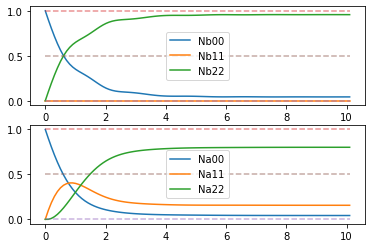

In [84]:
t = 10
steps = 100
dt = t/steps
rho_0 = np.kron(sigma(0,0), sigma(0,0))
GammaA = np.array([[1,1,1],[1,1,1],[1,1,1]])
GammaB = np.array([[1,1,1],[1,1,1],[1,1,1]])
Om_p = 1
Om = 1
Om_c = 1
Delta_c = -4
Vab = 1

H = H_a(Om_p, Om) + H_b(Om_c, Delta_c) + H_int(Vab)
evo = evolution(steps, dt, rho_0, H, GammaA, GammaB)
#rho_00 = [evo[i][0,0] for i in range(steps+1)]
#rho_11 = [evo[i][1,1] for i in range(steps+1)]
Nb00 = [np.trace(np.dot(evo[i],np.kron(np.eye(3),sigma(0,0)))) for i in range(steps+1)]
Nb11 = [np.trace(np.dot(evo[i],np.kron(np.eye(3),sigma(1,1)))) for i in range(steps+1)]
Nb22 = [np.trace(np.dot(evo[i],np.kron(np.eye(3),sigma(2,2)))) for i in range(steps+1)]

Na00 = [np.trace(np.dot(evo[i],np.kron(sigma(0,0),np.eye(3)))) for i in range(steps+1)]
Na11 = [np.trace(np.dot(evo[i],np.kron(sigma(1,1),np.eye(3)))) for i in range(steps+1)]
Na22 = [np.trace(np.dot(evo[i],np.kron(sigma(2,2),np.eye(3)))) for i in range(steps+1)]
times = np.linspace(0,dt*(steps+1), steps+1)

plt.subplot(211)

plt.plot(times, Nb00, label="Nb00")
plt.plot(times, Nb11, label="Nb11")
plt.plot(times, Nb22, label="Nb22")
plt.plot([0,times[-1]],[1,1],"--", alpha=0.5)
plt.plot([0,times[-1]],[0,0],"--", alpha=0.5)
plt.plot([0,times[-1]],[1/2,1/2],"--", alpha=0.5)
plt.legend()

plt.subplot(212)

plt.plot(times, Na00, label="Na00")
plt.plot(times, Na11, label="Na11")
plt.plot(times, Na22, label="Na22")
plt.plot([0,times[-1]],[1,1],"--", alpha=0.5)
plt.plot([0,times[-1]],[0,0],"--", alpha=0.5)
plt.plot([0,times[-1]],[1/2,1/2],"--", alpha=0.5)
plt.legend()

plt.show()

In [86]:
def fun(rho):
    Lmatrix = rho_dot(H, rho, GammaA, GammaB)
    

solve_ivp(fun, t_span=times, y0=np.kron(sigma(0,0), sigma(0,0)))

ValueError: too many values to unpack (expected 2)

changing the detuning

In [75]:
t = 10
steps = 100
dt = t/steps
rho_0 = np.kron(sigma(0,0), sigma(0,0))
GammaA = np.array([[1,1,1],[1,1,1],[1,1,1]])
GammaB = np.array([[1,1,1],[1,1,1],[1,1,1]])
Om_p = 1
Om = 1
Om_c = 1
Vab = 1

Nb = {"00":[],"11":[],"22":[]}
Na = {"00":[],"11":[],"22":[]}

values_delta_c = np.arange(0,-16, step=-2)
print(values_delta_c)

for Delta_c in values_delta_c:
    H = H_a(Om_p, Om) + H_b(Om_c, Delta_c) + H_int(Vab)
    evo = evolution(steps, dt, rho_0, H, GammaA, GammaB)

    Nb["00"].append(np.trace(np.dot(evo[-1],np.kron(np.eye(3),sigma(0,0)))))
    Nb["11"].append(np.trace(np.dot(evo[-1],np.kron(np.eye(3),sigma(1,1)))))
    Nb["22"].append(np.trace(np.dot(evo[-1],np.kron(np.eye(3),sigma(2,2)))))

    Na["00"].append(np.trace(np.dot(evo[-1],np.kron(sigma(0,0),np.eye(3)))))
    Na["11"].append(np.trace(np.dot(evo[-1],np.kron(sigma(1,1),np.eye(3)))))
    Na["22"].append(np.trace(np.dot(evo[-1],np.kron(sigma(2,2),np.eye(3)))))

[  0  -2  -4  -6  -8 -10 -12 -14]


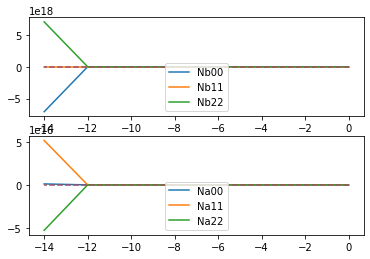

In [76]:
plt.subplot(211)

plt.plot(values_delta_c, Nb["00"], label="Nb00")
plt.plot(values_delta_c, Nb["11"], label="Nb11")
plt.plot(values_delta_c, Nb["22"], label="Nb22")
plt.plot([0,values_delta_c[-1]],[1,1],"--", alpha=0.5)
plt.plot([0,values_delta_c[-1]],[0,0],"--", alpha=0.5)
plt.plot([0,values_delta_c[-1]],[1/2,1/2],"--", alpha=0.5)
plt.legend()

plt.subplot(212)

plt.plot(values_delta_c, Na["00"], label="Na00")
plt.plot(values_delta_c, Na["11"], label="Na11")
plt.plot(values_delta_c, Na["22"], label="Na22")
plt.plot([0,values_delta_c[-1]],[1,1],"--", alpha=0.5)
plt.plot([0,values_delta_c[-1]],[0,0],"--", alpha=0.5)
plt.plot([0,values_delta_c[-1]],[1/2,1/2],"--", alpha=0.5)
plt.legend()

plt.show()